# Fine Tuning with Transfer Learning

> This is another type(Fine Tuning) of transfer Learning. First we did **Feature extration** which is another type of transfer learning


**Keras Sequential VS Function API** -> https://www.youtube.com/watch?v=EvGS3VAsG4Y 

**Docs** -> https://www.tensorflow.org/guide/keras/functional

In [130]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

In [131]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-07-30 07:12:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-30 07:12:54 (64.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [132]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Getting the data

In [133]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-30 07:12:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.220.208, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.220.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  62.6MB/s    in 2.6s    

2022-07-30 07:12:58 (62.6 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [134]:
unzip_data('10_food_classes_10_percent.zip')

In [135]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [136]:
train_dir= "10_food_classes_10_percent/train"
test_dir='10_food_classes_10_percent/test'

In [137]:
len(train_dir), len(test_dir)

(32, 31)

In [138]:
train_data=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [139]:
len(train_data)

24

In [140]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [141]:
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [142]:
len(train_data.class_names)

10

In [143]:
train_data.take

<bound method DatasetV2.take of <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>>

## Another Way to Build models

> We are using the **tf.keras.applications** or the **Keras Functional** API to build a model

Link -> https://www.tensorflow.org/api_docs/python/tf/keras/applications

> The Sequential API is straight-forward, it runs our layers in sequential order.

> But the functional API gives us the flexibility while creating the models

### Model_0, using transfer learning using feature extraction

In [144]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

In [145]:
# Create the base model
base_model= EfficientNetB0(include_top=False)

# Freeze the base model(The underlying pre-trained patterns aren't getting updated)
base_model.trainable=False

# Create inputs into the model
inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# If using a model of like ResNet50V2 we will need to normalize inputs(not needed for EfficientNet, has it has rescalling build-in)
# x =tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# Pass the inputs to base_model
x=base_model(inputs)

print(f"Shape after passing inputs: {x.shape}")

# Average pool the outputs of the base model(aggregrate all the most important information)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

print(f"Shape afterGlobalAveragePooling2D: {x.shape}")

# Ouput activation layer
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combining the input and output layers with the model
model_0= tf.keras.Model(inputs, outputs)

# Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit the model
model_0_history= model_0.fit(train_data, epochs=10, callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="efficientnet_bo_with_keras_functional_api")], steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data))


Shape after passing inputs: (None, 7, 7, 1280)
Shape afterGlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/efficientnet_bo_with_keras_functional_api/20220730-071303
Epoch 1/10
24/24 [==============================] - 15s 383ms/step - loss: 1.8634 - accuracy: 0.4307 - val_loss: 1.3163 - val_accuracy: 0.7112
Epoch 2/10
24/24 [==============================] - 8s 322ms/step - loss: 1.1193 - accuracy: 0.7533 - val_loss: 0.9056 - val_accuracy: 0.7988
Epoch 3/10
24/24 [==============================] - 8s 326ms/step - loss: 0.8264 - accuracy: 0.7987 - val_loss: 0.7414 - val_accuracy: 0.8164
Epoch 4/10
24/24 [==============================] - 8s 323ms/step - loss: 0.6698 - accuracy: 0.8427 - val_loss: 0.6553 - val_accuracy: 0.8244
Epoch 5/10
24/24 [==============================] - 8s 323ms/step - loss: 0.5888 - accuracy: 0.8600 - val_loss: 0.6068 - val_accuracy: 0.8296
Epoch 6/10
24/24 [==============================] - 8s 323ms/step - loss: 0.5241 - ac

In [146]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.4968 - accuracy: 0.8464


[0.49679887294769287, 0.8464000225067139]

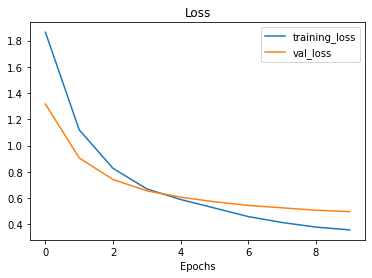

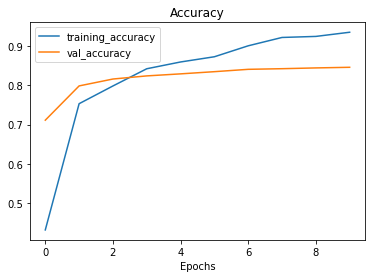

In [147]:
plot_loss_curves(model_0_history)

In [148]:
model_0.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## Explanation

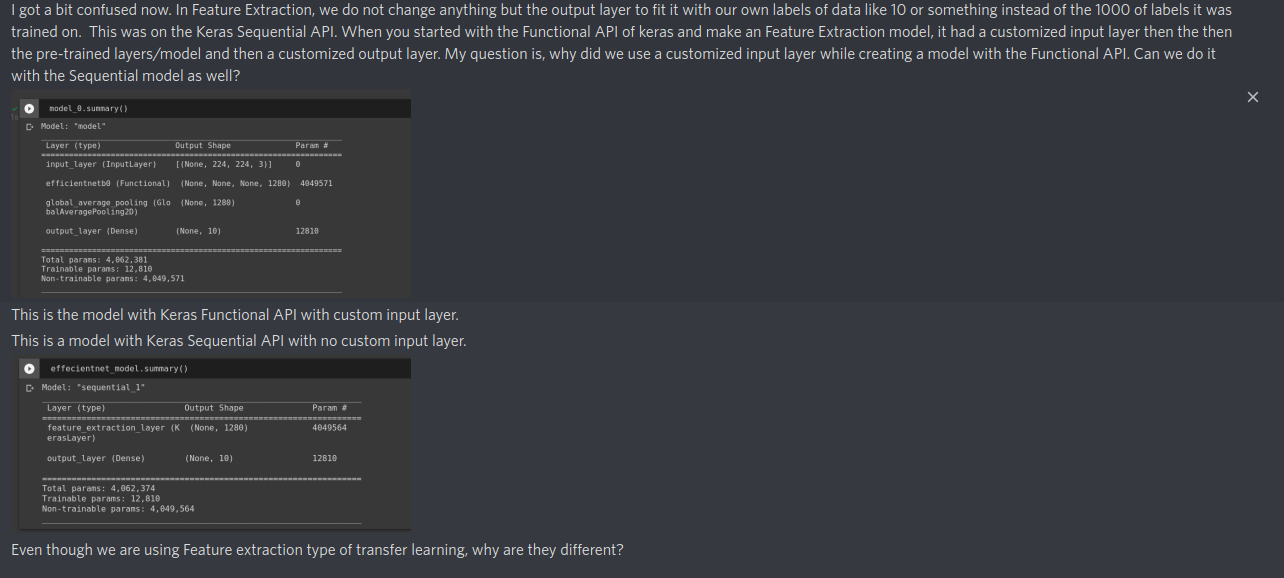

> This was the confusion I was having.

> This **model_0** is a transfer learning model using feature extraction. The difference here in **model_0** compared to previous model in the **transfer learning feature_extraction notebook** is that it had no **custom input layer**, only the output layer was changed to make it fit the number of classes as per the use case.

> But here in **model_0** we are using an **custom input layer** which is feeding our custom input to the **already pre-trained model** and an custom ouput layer to fit the number of classes as per the use case.

> So this is not limited to the **Keras Functional API**, I will try to replicate **model_0** with the **keras Sequential API** . I was tried it but it is giving me errors.


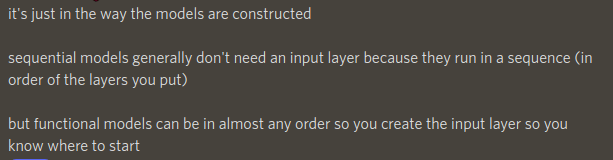



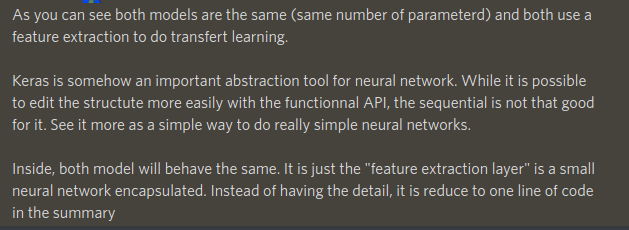








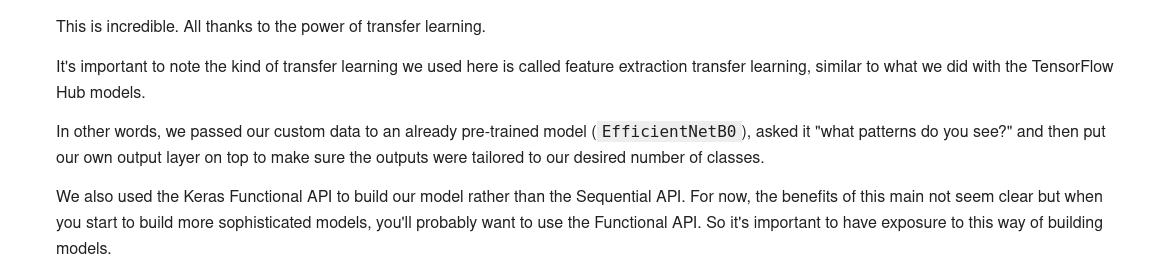

In [149]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_5 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   7          ['rescaling_5[0][0]']            
 )                              3)                                                   

### Layers in the base model

In [150]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_6
1 rescaling_5
2 normalization_5
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [151]:
len(base_model.layers)

237

## Model_0 copy with Keras sequential API


> Replicating the **model_0** with the keras sequential API to use a custom input to feed the custom data to the already pre-trained model.

In [152]:
# import tensorflow as tf
# import tensorflow_hub as hub
# from tensorflow.keras import layers

In [153]:
# efficientnet_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [154]:
# def create_model(model_url, num_classes=10):
#   """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
#   Args:
#     model_url (str): A TensorFlow Hub feature extraction URL.
#     num_classes (int): Number of output neurons in output layer,
#       should be equal to number of target classes, default 10.

#   Returns:
#     An uncompiled Keras Sequential model with model_url as feature
#     extractor layer and Dense output layer with num_classes outputs.
#   """
#   # Create an input layer to pass the custom data to the pretrained model
#   # inputs= tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
#   inputs=layers.Dense(input_shape=(224,224,3), activation="relu" ,name="input_layer")

#   # Download the pretrained model and save it as a Keras layer
#   feature_extractor_layer = hub.KerasLayer(model_url,
#                                            trainable=True, # freeze the underlying patterns
#                                            name='feature_extraction_layer')
        
  
#   # Create our own model
#   model = tf.keras.Sequential([
#     inputs,   # Input layer
#     feature_extractor_layer, # use the feature extraction layer 
#     layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
#   ])

#   return model

In [155]:
# model_0_sequential=create_model(efficientnet_url)

In [156]:
# model_0_sequential.summary()

## Getting a feature vector from the trained model

> We have a tensor from the **base_model** which has a shape of (None,7,7,1280)

> When this tensor passes through the **GlobalAveragePooling2D**, then the shape is (None, 1280)

> Let's see wha the **GlGlobalAveragePooling2D** layer does.

In [157]:
input_shape=(1,4,4,3)
tf.random.set_seed(42)
input_tensor= tf.random.normal(input_shape)
print(f"Random Input Tensor: {input_tensor}\n")

global_average_pooled_tensor= tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: {global_average_pooled_tensor}\n")

Random Input Tensor: [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: [[-0.09368646 -0.45840448 -0.2885598 ]]



In [158]:
input_tensor.shape

TensorShape([1, 4, 4, 3])

In [159]:
global_average_pooled_tensor.shape

TensorShape([1, 3])

In [160]:
newTensor= tf.reduce_mean(input_tensor, axis=[1,2])
newTensor,newTensor.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>,
 TensorShape([1, 3]))

In [161]:
global_max_pooled_tensor= tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
global_max_pooled_tensor, global_max_pooled_tensor.shape

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>,
 TensorShape([1, 3]))

## More experiments with transfer Learning

* `model_1` -> Transfer learning with feature extraction with 1% of the traning data with data augmentation.

* `model_2` -> Transfer learning with feature extraction with 10% of the traning data with data augmentation.

* `model_3` -> Transfer learning with fine tuning on 10% of the traning data with data augmentation

* `model_4` -> Transfer learning with fine tuning on 100% of the traning data with data augmentation

> Same test dataset will be used in all the model experiments for a proper evaluation.

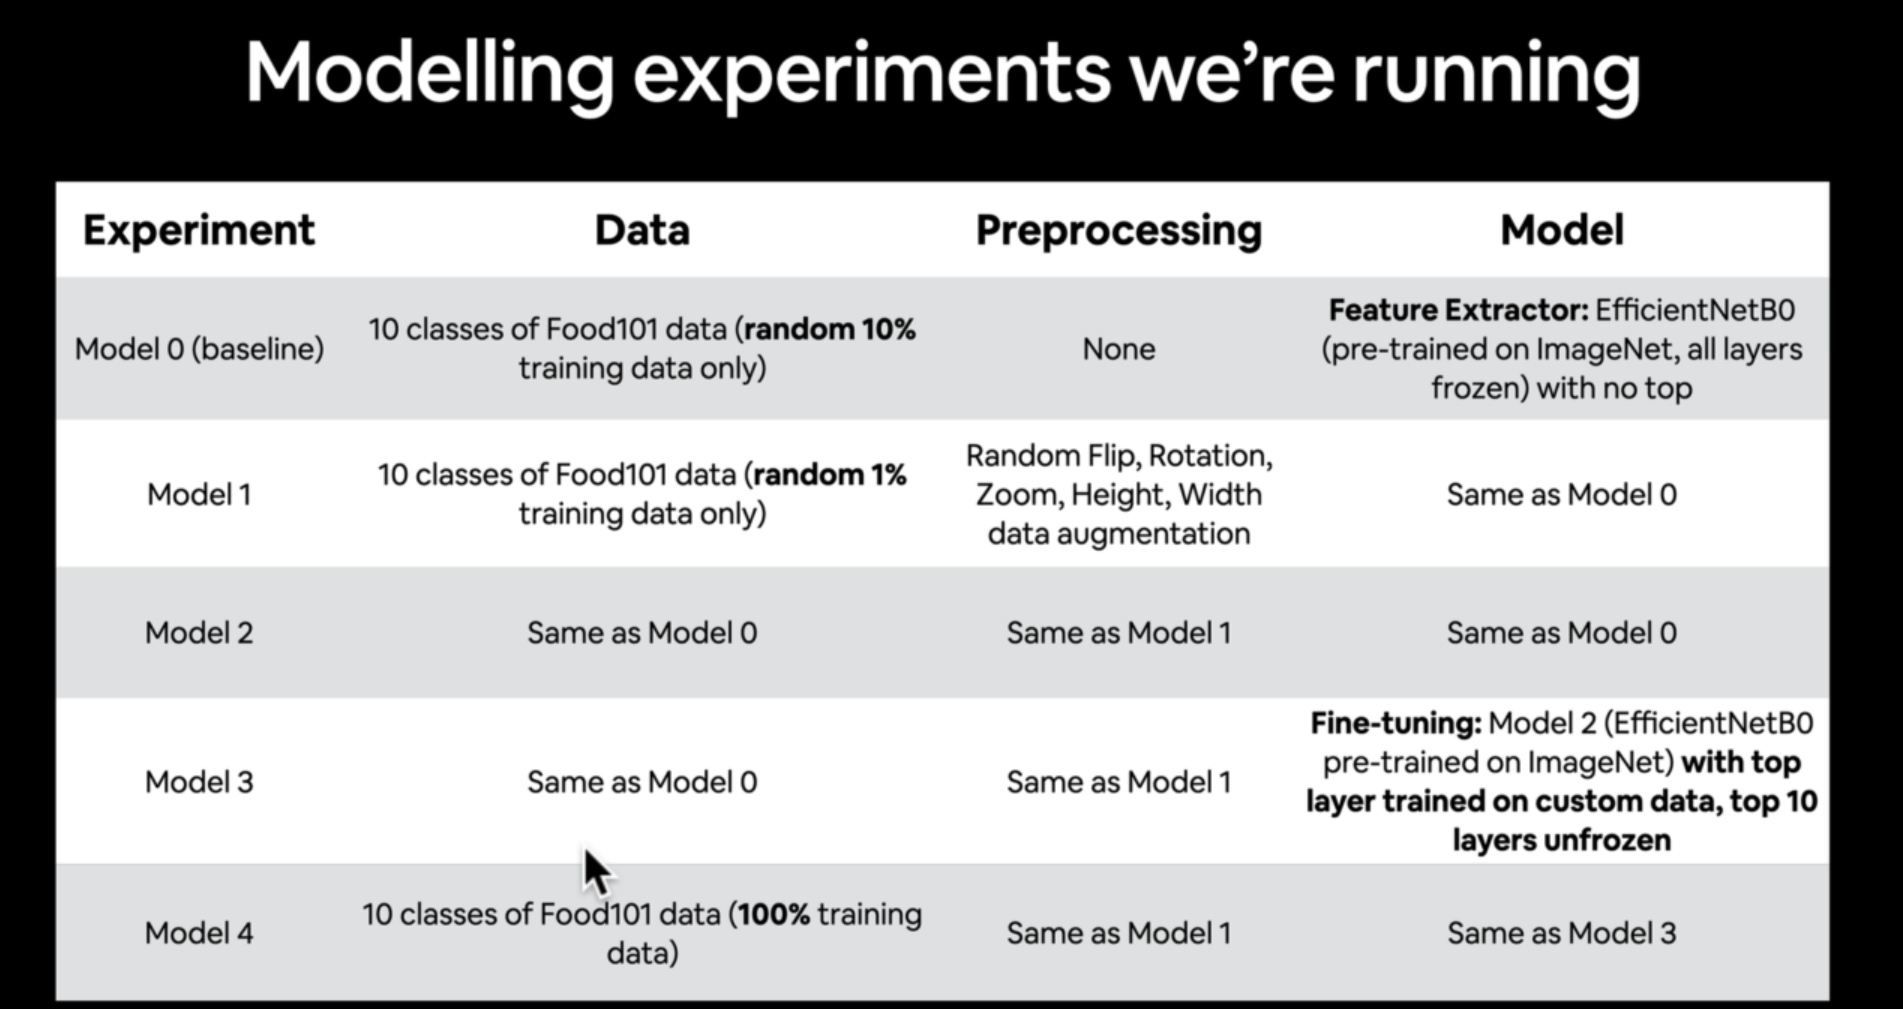

## Getting the data for model_1

In [162]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

--2022-07-30 07:14:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.1’

10_food_classes_1_p 100%[===================>] 127.42M  94.5MB/s    in 1.3s    

2022-07-30 07:14:46 (94.5 MB/s) - ‘10_food_classes_1_percent.zip.1’ saved [133612354/133612354]



In [163]:
unzip_data('10_food_classes_1_percent.zip')

In [164]:
train_dir_1_per= '10_food_classes_1_percent/train'
test_dir= '10_food_classes_1_percent/test'

In [165]:
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'

In [166]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_per= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding Data Augmentation right into the model

`Docs` -> https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

*`tf.keras.layers.experimental.preprocessing()`*

`Data Augmentation as a layer` -> https://www.tensorflow.org/tutorials/images/data_augmentation

In [167]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [168]:
data_augmentation= keras.Sequential([
                            preprocessing.RandomFlip("horizontal"),
                            preprocessing.RandomRotation(0.2),
                            preprocessing.RandomZoom(0.2),
                            preprocessing.RandomHeight(0.2),
                            preprocessing.RandomWidth(0.2),
                            # preprocessing.Rescaling(1./255) # Used for models like ResNetV2 but EfficientNet has rescale build-in
], name="data_augmentation")

### Visualizing the data augmentation layer

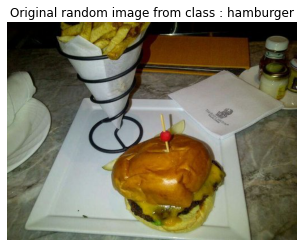

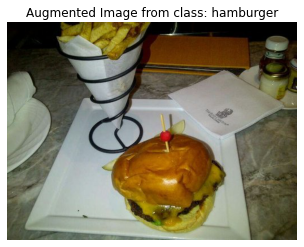

In [169]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

## Original Image
target_class= random.choice(train_data_1_per.class_names)
target_dir= train_dir_1_per + "/" + target_class
random_image= random.choice(os.listdir(target_dir))
random_image_path= target_dir + "/" + random_image
img= mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False);

## Augmented Image
plt.figure()
augmented_image= data_augmentation(img)
plt.imshow(augmented_image/255.)
plt.title(f"Augmented Image from class: {target_class}")
plt.axis(False);

In [170]:
train_data_1_per.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [171]:
train_dir_1_per + "/" + target_class


'10_food_classes_1_percent/train/hamburger'

In [172]:
target_class= random.choice(train_data_1_per.class_names)
target_class

'steak'

### `Model_1`: Feature extraction with transfer learning with 1% of the data with data augmentation

In [173]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_1= keras.Model(inputs, outputs)

# Compile model
model_1.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1_percent= model_1.fit(train_data_1_per, epochs=10, steps_per_epoch=len(train_data_1_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_augmented")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmented/20220730-071451
Epoch 1/10


3/3 [==============================] - ETA: 0s - loss: 2.4124 - accuracy: 0.0857WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


3/3 [==============================] - 15s 4s/step - loss: 2.4124 - accuracy: 0.0857 - val_loss: 2.2313 - val_accuracy: 0.1816
Epoch 2/10
3/3 [==============================] - 6s 3s/step - loss: 2.1865 - accuracy: 0.2429 - val_loss: 2.1157 - val_accuracy: 0.2456
Epoch 3/10
3/3 [==============================] - 6s 3s/step - loss: 2.0180 - accuracy: 0.4000 - val_loss: 2.0162 - val_accuracy: 0.3108
Epoch 4/10
3/3 [==============================] - 6s 3s/step - loss: 1.7514 - accuracy: 0.5286 - val_loss: 1.9235 - val_accuracy: 0.3668
Epoch 5/10
3/3 [==============================] - 6s 3s/step - loss: 1.6678 - accuracy: 0.5857 - val_loss: 1.8391 - val_accuracy: 0.4144
Epoch 6/10
3/3 [==============================] - 6s 3s/step - loss: 1.5151 - accuracy: 0.7286 - val_loss: 1.7621 - val_accuracy: 0.4620
Epoch 7/10
3/3 [==============================] - 6s 3s/step - loss: 1.3975 - accuracy: 0.7429 - val_loss: 1.6867 - val_accuracy: 0.5044
Epoch 8/10
3/3 [==============================] - 7

In [174]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 74ms/step - loss: 1.4931 - accuracy: 0.5988


[1.493135690689087, 0.598800003528595]

In [175]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [176]:
train_data_1_per

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [177]:
inputs

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_layer')>

### `Model_1_512`: Feature extraction with transfer learning with 1% of the data with data augmentation but with `IMG_SIZE=(512,512)` 

In [178]:
IMG_SIZE=(512,512)
BATCH_SIZE=32
train_data_1_per_512= tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_per, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

test_data_512= tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [179]:
input_shape=(512,512,3)
BATCH_SIZE=32

base_model_512= tf.keras.applications.EfficientNetB0(include_top=False)
base_model_512.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model_512(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_1_512= keras.Model(inputs, outputs)

# Compile model
model_1_512.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_1_percent_512= model_1_512.fit(train_data_1_per_512, epochs=10, steps_per_epoch=len(train_data_1_per_512), validation_data=test_data_512, validation_steps=len(test_data_512), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_augmented with (512,512) img_size")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_augmented with (512,512) img_size/20220730-071640
Epoch 1/10


3/3 [==============================] - ETA: 0s - loss: 2.3661 - accuracy: 0.0286WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 512, 512, 3).


3/3 [==============================] - 37s 15s/step - loss: 2.3661 - accuracy: 0.0286 - val_loss: 2.2731 - val_accuracy: 0.1140
Epoch 2/10
3/3 [==============================] - 31s 14s/step - loss: 2.1413 - accuracy: 0.2000 - val_loss: 2.1629 - val_accuracy: 0.2124
Epoch 3/10
3/3 [==============================] - 31s 14s/step - loss: 1.9783 - accuracy: 0.4571 - val_loss: 2.0747 - val_accuracy: 0.3016
Epoch 4/10
3/3 [==============================] - 31s 15s/step - loss: 1.8335 - accuracy: 0.4857 - val_loss: 1.9917 - val_accuracy: 0.3840
Epoch 5/10
3/3 [==============================] - 31s 14s/step - loss: 1.7192 - accuracy: 0.6143 - val_loss: 1.9146 - val_accuracy: 0.4536
Epoch 6/10
3/3 [==============================] - 31s 14s/step - loss: 1.6166 - accuracy: 0.7143 - val_loss: 1.8420 - val_accuracy: 0.5012
Epoch 7/10
3/3 [==============================] - 32s 15s/step - loss: 1.5005 - accuracy: 0.7000 - val_loss: 1.7732 - val_accuracy: 0.5300
Epoch 8/10
3/3 [======================

In [180]:
model_1_512.evaluate(test_data_512)

79/79 [==============================] - 27s 332ms/step - loss: 1.6069 - accuracy: 0.5880


[1.6068758964538574, 0.5879999995231628]

In [181]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (384, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [182]:
model_1_512.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 512, 512, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (384, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [183]:
results_1_percent_data_aug= model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 75ms/step - loss: 1.4931 - accuracy: 0.5988


[1.493135690689087, 0.598800003528595]

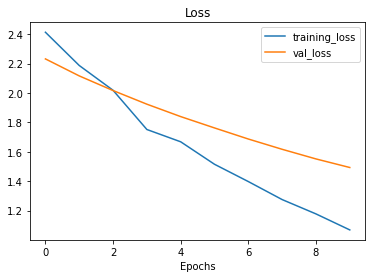

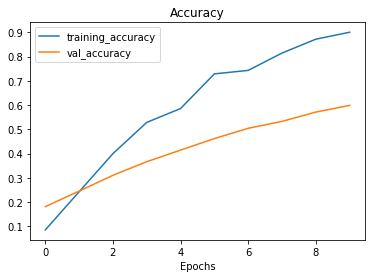

In [184]:
plot_loss_curves(history_1_percent)

## `Model_2`: Feature extraction with transfer learning with 10% of the data with data augmentation

In [185]:
IMG_SIZE=(224,224)
BATCH_SIZE=32

train_dir_10_per= "10_food_classes_10_percent/train"
test_dir='10_food_classes_10_percent/test'

train_data_10_per=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_10_per,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [186]:
walk_through_dir('10_food_classes_10_percent/')

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percen

In [187]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_2= keras.Model(inputs, outputs)

# Compile model
model_2.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_2_percent= model_2.fit(train_data_10_per, epochs=10, steps_per_epoch=len(train_data_10_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20220730-072414
Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 2.0277 - accuracy: 0.3400WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


24/24 [==============================] - 17s 476ms/step - loss: 2.0277 - accuracy: 0.3400 - val_loss: 1.4955 - val_accuracy: 0.6564
Epoch 2/10
24/24 [==============================] - 10s 417ms/step - loss: 1.3746 - accuracy: 0.6453 - val_loss: 1.0754 - val_accuracy: 0.7520
Epoch 3/10
24/24 [==============================] - 11s 438ms/step - loss: 1.0657 - accuracy: 0.7453 - val_loss: 0.8825 - val_accuracy: 0.7880
Epoch 4/10
24/24 [==============================] - 10s 395ms/step - loss: 0.9009 - accuracy: 0.7760 - val_loss: 0.7728 - val_accuracy: 0.8056
Epoch 5/10
24/24 [==============================] - 10s 409ms/step - loss: 0.7970 - accuracy: 0.8147 - val_loss: 0.7075 - val_accuracy: 0.8128
Epoch 6/10
24/24 [==============================] - 10s 398ms/step - loss: 0.7353 - accuracy: 0.8213 - val_loss: 0.6652 - val_accuracy: 0.8188
Epoch 7/10
24/24 [==============================] - 11s 475ms/step - loss: 0.6856 - accuracy: 0.8293 - val_loss: 0.6293 - val_accuracy: 0.8232
Epoch 8/10

In [188]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5680 - accuracy: 0.8308


[0.5679879188537598, 0.8307999968528748]

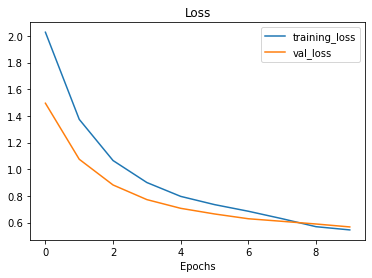

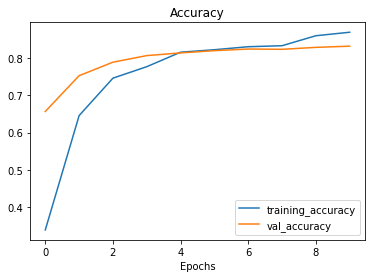

In [189]:
plot_loss_curves(history_2_percent)

In [190]:
results_2_percent_data_aug= model_2.evaluate(test_data)
results_2_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.5680 - accuracy: 0.8308


[0.5679879188537598, 0.8307999968528748]

In [191]:
results_1_percent_data_aug

[1.493135690689087, 0.598800003528595]

In [192]:
model_2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (384, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [193]:
model_1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (384, 512, 3)            0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [194]:
model_0.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### Creating a ModelCheckpoint callback

`tf.keras.callbacks.ModelCheckpoint()`

> It intermdediately saves the model(the full model or just the weights) during training. This is useful so that we can come and start from where we left off.

In [195]:
checkpoint_path='ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# ModelCheckpoint callback(Just save the model's weights only)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", verbose=1)

### `model_2` again but with ModelCheckpoint callaback added

In [196]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_2_checkpoint= keras.Model(inputs, outputs)

# Compile model
model_2_checkpoint.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

history_2_checkpoint_percent= model_2_checkpoint.fit(train_data_10_per, epochs=10, steps_per_epoch=len(train_data_10_per), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_augmented"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_augmented/20220730-072620
Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 2.0468 - accuracy: 0.2853WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).



Epoch 1: val_loss improved from inf to 1.47749, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 17s 462ms/step - loss: 2.0468 - accuracy: 0.2853 - val_loss: 1.4775 - val_accuracy: 0.6364
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3905 - accuracy: 0.6373
Epoch 2: val_loss improved from 1.47749 to 1.05461, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 408ms/step - loss: 1.3905 - accuracy: 0.6373 - val_loss: 1.0546 - val_accuracy: 0.7748
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0738 - accuracy: 0.7173
Epoch 3: val_loss improved from 1.05461 to 0.85715, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 420ms/step - loss: 1.0738 - accuracy: 0.7173 - val_loss: 0.8572 - val_accuracy: 0.8028
Epoch 4/10
24/24 [==============================] - E

In [197]:
model_0.evaluate(test_data)

79/79 [==============================] - 7s 73ms/step - loss: 0.4968 - accuracy: 0.8464


[0.49679869413375854, 0.8464000225067139]

In [198]:
model_1.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 1.4931 - accuracy: 0.5988


[1.4931353330612183, 0.598800003528595]

In [199]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5680 - accuracy: 0.8308


[0.5679879188537598, 0.8307999968528748]

In [200]:
model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5549 - accuracy: 0.8388


[0.5548509955406189, 0.8388000130653381]

In [201]:
results_2_percent_checkpoint_data_aug= model_2_checkpoint.evaluate(test_data)
results_2_percent_checkpoint_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.5549 - accuracy: 0.8388


[0.5548509955406189, 0.8388000130653381]

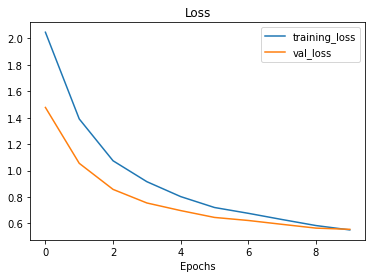

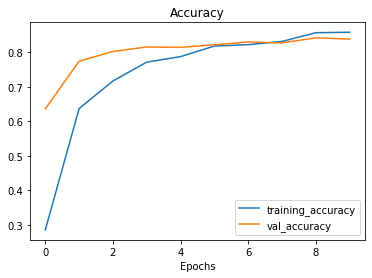

In [202]:
plot_loss_curves(history_2_checkpoint_percent)

### Loading the Checkpointed weights

> Loading in checkpointed weights returns a model to a specific checkpoint

#### Load in saved model weights and evaluate model

In [203]:
model_2_checkpoint.weights

[<tf.Variable 'normalization_9/mean:0' shape=(3,) dtype=float32, numpy=array([0.485, 0.456, 0.406], dtype=float32)>,
 <tf.Variable 'normalization_9/variance:0' shape=(3,) dtype=float32, numpy=array([0.229, 0.224, 0.225], dtype=float32)>,
 <tf.Variable 'normalization_9/count:0' shape=() dtype=int64, numpy=0>,
 <tf.Variable 'stem_conv/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
 array([[[[ 2.07668245e-02,  8.53624821e-01, -9.72171009e-01,
            5.80005467e-01,  3.13335508e-02, -1.81043148e-02,
           -1.28635168e-02,  5.94060645e-02, -7.41896749e-01,
           -2.27897346e-01,  2.00766921e-01, -2.33019665e-02,
           -3.82314444e-01, -1.13366711e+00, -4.97356057e-02,
           -5.28575480e-01,  6.01686649e-02,  3.28413874e-01,
            7.26403654e-01,  9.56093222e-02,  2.53003836e-03,
            7.99428642e-01,  1.60467178e-01,  1.51992925e-02,
            2.15564728e-01, -6.15406692e-01,  7.56446272e-02,
            3.47692966e-02,  0.00000000e+00, -6.2799476

In [204]:
len(model_2_checkpoint.weights)

314

In [205]:
model_2_checkpoint.load_weights(checkpoint_path)

#### Evaluating the model with the loaded_weights from the `Modelchcekpoint callback`

In [206]:
loaded_weights_model_results= model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5549 - accuracy: 0.8388


In [207]:
results_2_percent_checkpoint_data_aug

[0.5548509955406189, 0.8388000130653381]

In [208]:
loaded_weights_model_results == results_2_percent_checkpoint_data_aug

False

### `Model_3`: Fine Tuning with transfer learning with 10% of the data with data augmentation

> Fine -tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data.

>So in reality, `model_3`, is a fine-tunied model of `model_2`

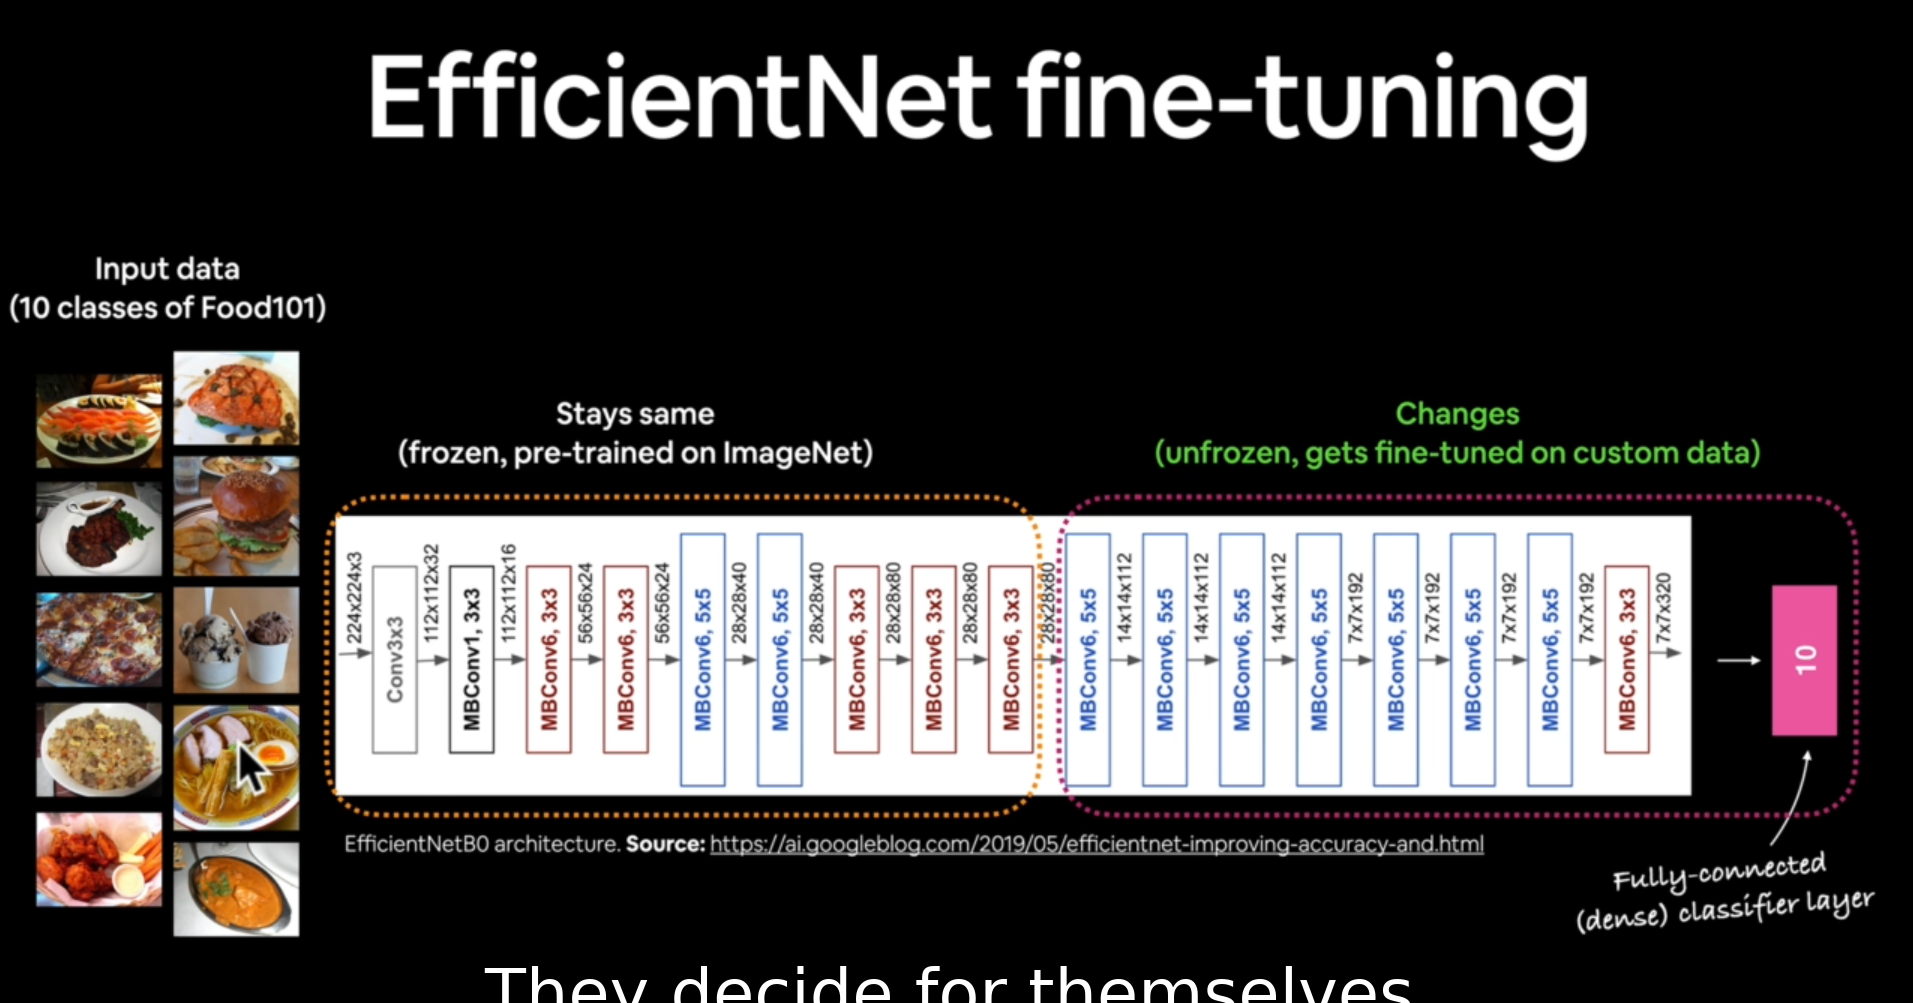



In [209]:
model_2_checkpoint.layers

### Checking for trainable layers

In [210]:
for layer in model_2_checkpoint.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f47a39d1810> True
<keras.engine.sequential.Sequential object at 0x7f492970bed0> True
<keras.engine.functional.Functional object at 0x7f47a2342490> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f4799058550> True
<keras.layers.core.dense.Dense object at 0x7f4ad26c6310> True


In [211]:
for layer in model_2_checkpoint.layers[2].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4799058610> input_10 False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f47990b4d10> rescaling_9 False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f4799058c90> normalization_9 False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f47990598d0> stem_conv_pad False
<keras.layers.convolutional.Conv2D object at 0x7f47990b4790> stem_conv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f498af5d5d0> stem_bn False
<keras.layers.core.activation.Activation object at 0x7f498afc0450> stem_activation False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f479906a210> block1a_dwconv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f47a39d1550> block1a_bn False
<keras.layers.core.activation.Activation object at 0x7f47a2e11cd0> block1a_activation False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f479

### Layers in the `base_model` from the EfficientNet_B0.

In [212]:
for i, layer in enumerate(model_2_checkpoint.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_10 False
1 rescaling_9 False
2 normalization_9 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

### Trainable variables

> It is a weight or pattern that can be updated.

In [213]:
len(model_2_checkpoint.layers[2].trainable_variables)

0

In [214]:
len(model_2_checkpoint.layers[0].trainable_variables)

0

In [215]:
len(model_2_checkpoint.layers)

5

In [216]:
model_2_checkpoint.trainable_variables

[<tf.Variable 'output_layer/kernel:0' shape=(1280, 10) dtype=float32, numpy=
 array([[-0.00611825, -0.02951297,  0.0538171 , ..., -0.03362495,
         -0.02226332,  0.03302906],
        [-0.00443001, -0.05656313, -0.00560561, ...,  0.08651533,
         -0.05661978,  0.05052144],
        [-0.03840938,  0.04180372,  0.05583441, ..., -0.00413507,
         -0.04728866,  0.06043804],
        ...,
        [-0.00697434, -0.00505215,  0.00063878, ...,  0.029695  ,
          0.06990211,  0.04017393],
        [-0.04487078, -0.00999324, -0.0298392 , ..., -0.04573428,
          0.09383892,  0.06571396],
        [-0.03680442, -0.06956845,  0.08664603, ..., -0.00385295,
         -0.01098394,  0.10601897]], dtype=float32)>,
 <tf.Variable 'output_layer/bias:0' shape=(10,) dtype=float32, numpy=
 array([ 0.00037963, -0.00409382,  0.01104952, -0.01879038,  0.00732068,
         0.01086452,  0.01845179, -0.00126007, -0.01234564, -0.00557194],
       dtype=float32)>]

In [217]:
len(model_2_checkpoint.trainable_variables)

2

### Fine-Tuning model

> Try and set the last 10 layers of the `base_model` layers from `trainable=False` to `trainable=True`. 

**base_model.trainable=True**

> When we want to fine-tune or fine-tuning our model, we usually want to lower the `learning_rate`, so that the already trained weights of the model do not change drastically, otherwise it will lead to overfitting of the model. 

> Usually we lower it by atleast `10x`, if it was **0.001** which is default `learning_rate` from **Adam** optimizer, when fine-tuning the model, we should decrease the `learning_rate` to **0.0001**.

In [218]:
len(base_model.layers)

237

In [219]:
len(base_model.layers[:-10])

227

In [220]:
for layer in base_model.layers[:-10]:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f4799058610> input_10 False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f47990b4d10> rescaling_9 False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f4799058c90> normalization_9 False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f47990598d0> stem_conv_pad False
<keras.layers.convolutional.Conv2D object at 0x7f47990b4790> stem_conv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f498af5d5d0> stem_bn False
<keras.layers.core.activation.Activation object at 0x7f498afc0450> stem_activation False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f479906a210> block1a_dwconv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f47a39d1550> block1a_bn False
<keras.layers.core.activation.Activation object at 0x7f47a2e11cd0> block1a_activation False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f479

In [221]:
base_model.trainable=True

# Freeze all the layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable= False

# Recompile the model(we have to recompile the models everytime we make a change)
model_2_checkpoint.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [222]:
for layer_number, layer in enumerate(model_2_checkpoint.layers[2].layers):
  if layer.trainable == True:
    print(layer_number, layer.name, layer.trainable)

227 block7a_se_squeeze True
228 block7a_se_reshape True
229 block7a_se_reduce True
230 block7a_se_expand True
231 block7a_se_excite True
232 block7a_project_conv True
233 block7a_project_bn True
234 top_conv True
235 top_bn True
236 top_activation True


In [223]:
for layer_number, layer in enumerate(model_2_checkpoint.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_10 False
1 rescaling_9 False
2 normalization_9 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

#### Count of trainable_variables

In [224]:
print(len(model_2_checkpoint.trainable_variables))

12


### Fine-Tune for another `10` epochs

> We know that the `model_2_checkpoint` model was trained for `10` epochs earlier with `transfer learning using feature extraction`. Now we will use that model(model_2_checkpoint) and `fine-tune` it with `10 trainable layer` for `10` epochs.

In [225]:
initial_epochs=10

In [226]:
# Fine tune for another 10 epochs
fine_tune_epochs= initial_epochs + 10

# Refit the model(model_2_checkpoint with more trainable layers)
history_3_fine_tune_data_aug= model_2_checkpoint.fit(train_data_10_per, epochs=fine_tune_epochs, validation_data=test_data, validation_steps=len(test_data), initial_epoch=history_2_checkpoint_percent.epoch[-1], callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_fine_tune_last_10_layers"), checkpoint_callback]) # Start training from previous last epoch

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20220730-072932
Epoch 10/20


24/24 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8547WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).



Epoch 10: val_loss improved from 0.55485 to 0.49369, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 512ms/step - loss: 0.4809 - accuracy: 0.8547 - val_loss: 0.4937 - val_accuracy: 0.8400
Epoch 11/20
24/24 [==============================] - ETA: 0s - loss: 0.4014 - accuracy: 0.8800
Epoch 11: val_loss improved from 0.49369 to 0.48844, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 404ms/step - loss: 0.4014 - accuracy: 0.8800 - val_loss: 0.4884 - val_accuracy: 0.8372
Epoch 12/20
24/24 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8987
Epoch 12: val_loss improved from 0.48844 to 0.48341, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 420ms/step - loss: 0.3461 - accuracy: 0.8987 - val_loss: 0.4834 - val_accuracy: 0.8380
Epoch 13/20
24/24 [=========================

In [227]:
model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.5026 - accuracy: 0.8340


[0.5026116967201233, 0.8339999914169312]

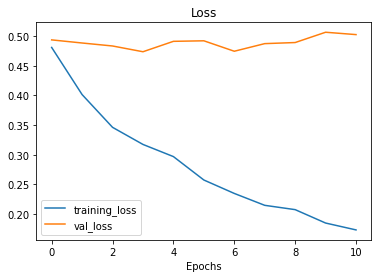

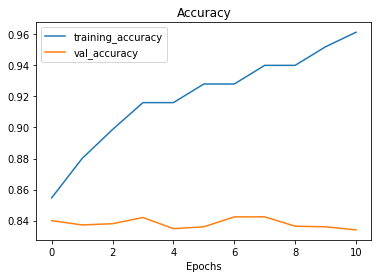

In [228]:
plot_loss_curves(history_3_fine_tune_data_aug)

In [229]:
results_fine_tune_10_percent=model_2_checkpoint.evaluate(test_data)
results_fine_tune_10_percent

79/79 [==============================] - 6s 72ms/step - loss: 0.5026 - accuracy: 0.8340


[0.5026116371154785, 0.8339999914169312]

In [230]:
results_2_percent_checkpoint_data_aug

[0.5548509955406189, 0.8388000130653381]

> Function to compare graphs between the `model before fine-tuning` and the graph after the `model being fine-tuned`

In [234]:
def compare_histories(original_history, new_history, initial_epochs=10):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots for accuracy
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Make plots for loss

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

10
21
[0.2853333353996277, 0.637333333492279, 0.7173333168029785, 0.7720000147819519, 0.7879999876022339, 0.8186666369438171, 0.8226666450500488, 0.8320000171661377, 0.8573333621025085, 0.8586666584014893, 0.8546666502952576, 0.8799999952316284, 0.8986666798591614, 0.9160000085830688, 0.9160000085830688, 0.9279999732971191, 0.9279999732971191, 0.9399999976158142, 0.9399999976158142, 0.9520000219345093, 0.9613333344459534]


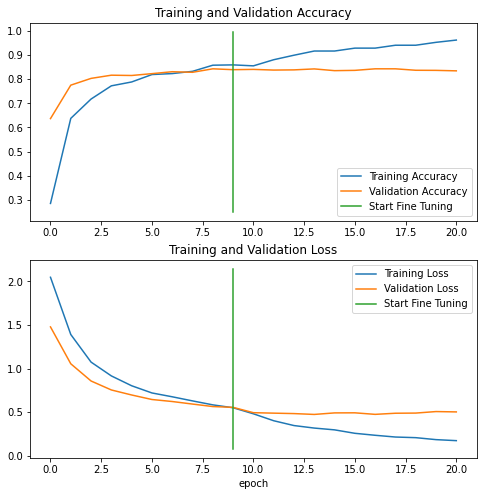

In [235]:
compare_histories(history_2_checkpoint_percent,history_3_fine_tune_data_aug)

### `model_4` transfer learning with fine-tuning with 100% of the training data.

> `Feature-extraction` works great with `lower amount of data`.

> Fine-Tuning works best with `more data`. So more the data, `better the accuracy`.

In [236]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

--2022-07-30 07:57:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  30.1MB/s    in 12s     

2022-07-30 07:57:27 (41.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [237]:
unzip_data('10_food_classes_all_data.zip')

In [238]:
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [239]:
train_dir_all= "10_food_classes_all_data/train"
test_dir='10_food_classes_all_data/test'

In [240]:
IMG_SIZE= (224,224)
BATCH_SIZE=32

train_data_all=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,image_size=IMG_SIZE, label_mode="categorical", batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Feature Extraction with all training data

In [249]:
input_shape=(224,224,3)
BATCH_SIZE=32

base_model= tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Input Layer
inputs= layers.Input(shape=input_shape, name="input_layer")

# Add data augmentation as a layer
x= data_augmentation(inputs)

# Giving the inputs to base_model
x= base_model(x, training=False)

# Pool the output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Dense layer as the output layer
outputs= layers.Dense(10, activation="softmax", name="output_layer")(x)

# Building the model
model_4= keras.Model(inputs, outputs)

# Compile model
model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

model_4_history= model_4.fit(train_data_all, epochs=10, steps_per_epoch=len(train_data_all), validation_data=test_data, validation_steps=len(test_data), callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="feature_extraction_all_data"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/feature_extraction_all_data/20220730-081624
Epoch 1/10


235/235 [==============================] - ETA: 0s - loss: 1.0630 - accuracy: 0.6899WARNING:tensorflow:Model was constructed with shape (384, 512, 3) for input KerasTensor(type_spec=TensorSpec(shape=(384, 512, 3), dtype=tf.uint8, name='random_flip_1_input'), name='random_flip_1_input', description="created by layer 'random_flip_1_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).



Epoch 1: val_loss did not improve from 0.47369
235/235 [==============================] - 50s 185ms/step - loss: 1.0630 - accuracy: 0.6899 - val_loss: 0.5240 - val_accuracy: 0.8464
Epoch 2/10
235/235 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.7864
Epoch 2: val_loss improved from 0.47369 to 0.43714, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 38s 162ms/step - loss: 0.6963 - accuracy: 0.7864 - val_loss: 0.4371 - val_accuracy: 0.8596
Epoch 3/10
235/235 [==============================] - ETA: 0s - loss: 0.6092 - accuracy: 0.8093
Epoch 3: val_loss improved from 0.43714 to 0.40989, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 37s 158ms/step - loss: 0.6092 - accuracy: 0.8093 - val_loss: 0.4099 - val_accuracy: 0.8668
Epoch 4/10
235/235 [==============================] - ETA: 0s - loss: 0.5706 - accuracy: 0.8212
Epoch 4: val_loss 

In [250]:
model_4.evaluate(test_data)

79/79 [==============================] - 7s 84ms/step - loss: 0.3579 - accuracy: 0.8808


[0.3578551113605499, 0.8808000087738037]

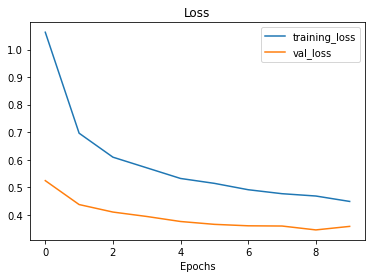

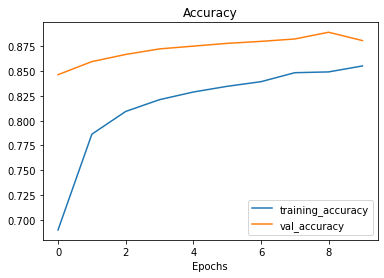

In [251]:
plot_loss_curves(model_4_history)

In [252]:
result_4_feature_extraction_all= model_4.evaluate(test_data)
result_4_feature_extraction_all

79/79 [==============================] - 6s 72ms/step - loss: 0.3579 - accuracy: 0.8808


[0.3578549325466156, 0.8808000087738037]

In [253]:
model_4.layers

In [254]:
for layer in model_4.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f47916d4690> True
<keras.engine.sequential.Sequential object at 0x7f492970bed0> True
<keras.engine.functional.Functional object at 0x7f47933a9350> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f47933ae150> True
<keras.layers.core.dense.Dense object at 0x7f4793378dd0> True


In [255]:
len(model_4.layers[2].layers[:-10])

227

In [256]:
len(model_4.layers[2].layers)

237

In [257]:
for layer in model_4.layers[2].layers[:-10]:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f47916d4ad0> False
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f47916c8690> False
<keras.layers.preprocessing.normalization.Normalization object at 0x7f47916d4f90> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f47916d4250> False
<keras.layers.convolutional.Conv2D object at 0x7f47946c5fd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f4794545dd0> False
<keras.layers.core.activation.Activation object at 0x7f478becd310> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f479827fbd0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f47916d2850> False
<keras.layers.core.activation.Activation object at 0x7f47916d2510> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f47916d79d0> False
<keras.layers.core.reshape.Reshape object at 0x7f47916cc510> False
<keras.layers.convolutional.Conv2D object at 0x7

### Making the last 10 layers trainable for fine-tuning of the model

In [272]:
base_model.trainable=True

for layer in base_model.layers[:-10]:
  layer.trainable= False

model_4.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

In [276]:
for layer in model_4.layers[2].layers:
  if layer.trainable == True:
    print(layer, layer.trainable)

<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f479339a290> True
<keras.layers.core.reshape.Reshape object at 0x7f47933a20d0> True
<keras.layers.convolutional.Conv2D object at 0x7f47933e9390> True
<keras.layers.convolutional.Conv2D object at 0x7f47933cdfd0> True
<keras.layers.merge.Multiply object at 0x7f47933e5290> True
<keras.layers.convolutional.Conv2D object at 0x7f47934202d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f479343ac90> True
<keras.layers.convolutional.Conv2D object at 0x7f478becd850> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f479339ff90> True
<keras.layers.core.activation.Activation object at 0x7f479339f150> True


In [278]:
len(model_4.trainable_variables)

12

## Fine-Tuning the model, `model_4`

In [280]:
fine_tune_epochs= initial_epochs + 10
model_4_history_fine_tuned= model_4.fit(train_data_all, epochs=fine_tune_epochs, validation_data=test_data, validation_steps=len(test_data), initial_epoch=model_4_history.epoch[-1], callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="fine_tuning_with_all_data"), checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/fine_tuning_with_all_data/20220730-084047
Epoch 10/20
235/235 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.9037
Epoch 10: val_loss did not improve from 0.32942
235/235 [==============================] - 36s 148ms/step - loss: 0.3049 - accuracy: 0.9037 - val_loss: 0.3501 - val_accuracy: 0.8848
Epoch 11/20
235/235 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.9069
Epoch 11: val_loss improved from 0.32942 to 0.30625, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
235/235 [==============================] - 31s 131ms/step - loss: 0.2857 - accuracy: 0.9069 - val_loss: 0.3063 - val_accuracy: 0.9020
Epoch 12/20
235/235 [==============================] - ETA: 0s - loss: 0.2620 - accuracy: 0.9183
Epoch 12: val_loss did not improve from 0.30625
235/235 [==============================] - 29s 123ms/step - loss: 0.2620 - accuracy: 0.9183 - val_loss: 0.3139 - val_accuracy: 0.

In [281]:
model_4.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.3402 - accuracy: 0.8908


[0.3401765525341034, 0.8907999992370605]

In [287]:
results_fine_tune_10_percent

[0.5026116371154785, 0.8339999914169312]

10
21
[0.6898666620254517, 0.7864000201225281, 0.809333324432373, 0.8212000131607056, 0.8289333581924438, 0.8346666693687439, 0.8393333554267883, 0.8483999967575073, 0.8492000102996826, 0.8551999926567078, 0.9037333130836487, 0.9069333076477051, 0.9182666540145874, 0.9218666553497314, 0.9327999949455261, 0.9334666728973389, 0.9387999773025513, 0.9429333209991455, 0.9485333561897278, 0.9508000016212463, 0.9535999894142151]


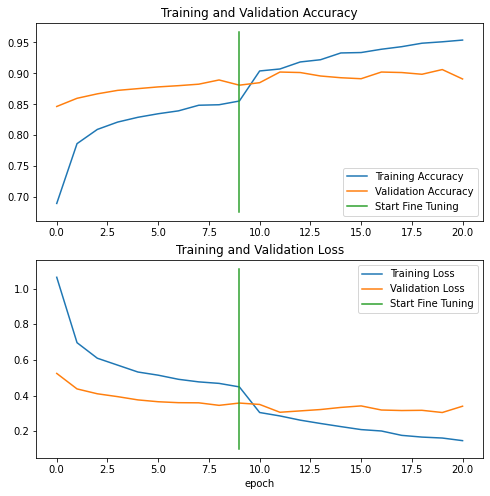

In [282]:
compare_histories(model_4_history,model_4_history_fine_tuned)

In [289]:
result_4_fine_tuned_all=model_4.evaluate(test_data)
result_4_fine_tuned_all

79/79 [==============================] - 8s 84ms/step - loss: 0.3402 - accuracy: 0.8908


[0.3401765525341034, 0.8907999992370605]

## `model_4_a` we need to revert model_2 back to it's feature extraction weights



* Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
    
* Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
    
* Saved the results and training logs each time.

* Reloaded the model from 1 to do the same steps as 2 but with all of the data.

> The same steps as 2?

* Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.


In [284]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [285]:
model_2_checkpoint.load_weights(checkpoint_path)

In [288]:
model_2_checkpoint.evaluate(test_data)

79/79 [==============================] - 9s 75ms/step - loss: 0.3048 - accuracy: 0.9060


[0.3048214018344879, 0.906000018119812]

In [291]:
for layer_number, layer in enumerate(model_2_checkpoint.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_10 False
1 rescaling_9 False
2 normalization_9 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resh

## Viewing experiment data using tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning experiments with the 101Food classes but using 10 classes only." \
--description "A series of transfer learning experiments using feature extraction as well as fine tuning" \
--one_shot

## Tensorboard Link 

Link -> https://tensorboard.dev/experiment/0IxgEbN9QJ6Ziq2xh7PUGw/

In [297]:
!tensorboard dev list

https://tensorboard.dev/experiment/0IxgEbN9QJ6Ziq2xh7PUGw/
	Name                 Transfer Learning experiments with the 101Food classes but using 10 classes only.
	Description          A series of transfer learning experiments using feature extraction as well as fine tuning
	Id                   0IxgEbN9QJ6Ziq2xh7PUGw
	Created              2022-07-30 09:06:49 (7 minutes ago)
	Updated              2022-07-30 09:07:17 (6 minutes ago)
	Runs                 34
	Tags                 5
	Scalars              1002
	Tensor bytes         0
	Binary object bytes  14696011
Total: 1 experiment(s)
